In [1]:
import random

import numpy as np
from PIL import Image
import tensorflow as tf

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPool2D

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Loading MNIST Dataset from keras

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(f'Shape of training dataset: {np.shape(X_train)}')
print(f'Shape of testing dataset: {np.shape(X_test)}')

Shape of training dataset: (60000, 28, 28)
Shape of testing dataset: (10000, 28, 28)


In [0]:
#Creating Custom Dataset for digits in sequence

def build_dataset(data, labels, dataset_size):
  new_img_width = 64
  new_img_height = 64

  new_data = np.ndarray(shape=(dataset_size, new_img_height, new_img_width), dtype=np.float32)
  new_labels = []

  for i in range(0, dataset_size):
    num_digits = random.randint(1, 5)

    indices = [random.randint(0, len(data)-1) for _ in range(0, num_digits)]
    new_image = np.hstack([X_train[index] for index in indices])
    new_label = [y_train[index] for index in indices]

    for j in range(0, 5-num_digits):
      new_image = np.hstack([new_image, np.zeros((28, 28))])
      new_label.append(10)

    new_image = np.array(Image.fromarray(new_image).resize((64, 64)))
    new_data[i,:,:] = new_image
    new_labels.append(tuple(new_label))
  
  return new_data, new_labels


In [0]:
#Building new Training and Testing Dataset

X_new_train, y_new_train = build_dataset(X_train, y_train, 60000)
X_new_test, y_new_test = build_dataset(X_train, y_train, 60000)

(3, 0, 4, 7, 10)


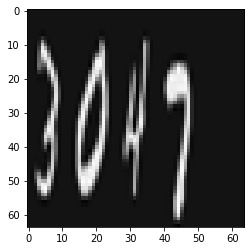

In [6]:
plt.figure()
plt.imshow(X_new_train[108], cmap='gray')
print(y_new_train[108])

# here 10 shows empty space

In [0]:
#Conver labels to One-hot representation of shape (set_Size, digits, classes)
#Possible Classes are 11 because there are 0-9 digits and another class to represent that no number was there hence 11 classes
possible_classes = 11

def convert_labels(labels):
  dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig3_arr = np.ndarray(shape=(len(labels),possible_classes)) 
  dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
  for index, label in enumerate(labels):
    dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
    dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
    dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
    dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
    dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)

  return [dig0_arr, dig1_arr, dig2_arr, dig3_arr, dig4_arr]

In [8]:
train_labels = convert_labels(y_new_train)
test_labels = convert_labels(y_new_test)

print(np.shape(train_labels))

(5, 60000, 11)


In [0]:
#Preprocessing Images

def process_data(img_data):
  img_data = img_data.reshape(len(img_data),64,64,1)
  img_data = img_data.astype('float32')
  img_data = img_data/255
  return img_data

In [0]:
train_images = process_data(X_new_train)
test_images = process_data(X_new_test)

In [0]:
# Model Building

batch_size = 128

inputs = Input(shape=(64, 64, 1))

cov = Convolution2D(32, 3, strides=3, padding='same', activation='relu')(inputs)
cov = Convolution2D(32, 3, strides=3, padding='same', activation='relu')(cov)
cov = MaxPool2D(pool_size=(2, 2))(cov)
cov = Dropout(0.25)(cov)
cov = Flatten()(cov)

cov = Dense(128, activation='relu')(cov)
cov = Dropout(0.5)(cov)

c0 = Dense(11, activation='softmax')(cov)
c1 = Dense(11, activation='softmax')(cov)
c2 = Dense(11, activation='softmax')(cov)
c3 = Dense(11, activation='softmax')(cov)
c4 = Dense(11, activation='softmax')(cov)

model = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.fit(train_images, train_labels, batch_size=batch_size, epochs=15, 
          verbose=1, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 9s 144us/step - loss: 6.0966 - dense_2_loss: 1.6091 - dense_3_loss: 1.5507 - dense_4_loss: 1.3524 - dense_5_loss: 1.0145 - dense_6_loss: 0.5692 - dense_2_accuracy: 0.4319 - dense_3_accuracy: 0.4584 - dense_4_accuracy: 0.5345 - dense_5_accuracy: 0.6672 - dense_6_accuracy: 0.8243 - val_loss: 3.4131 - val_dense_2_loss: 0.7380 - val_dense_3_loss: 0.8486 - val_dense_4_loss: 0.8260 - val_dense_5_loss: 0.6520 - val_dense_6_loss: 0.3485 - val_dense_2_accuracy: 0.8056 - val_dense_3_accuracy: 0.7769 - val_dense_4_accuracy: 0.7806 - val_dense_5_accuracy: 0.8077 - val_dense_6_accuracy: 0.9025
Epoch 2/15
60000/60000 [==============================] - 7s 120us/step - loss: 4.0727 - dense_2_loss: 0.9809 - dense_3_loss: 1.0195 - dense_4_loss: 0.9388 - dense_5_loss: 0.7341 - dense_6_loss: 0.3993 - dense_2_accuracy: 0.6644 - dense_3_accuracy: 0.6500 - dense_4_accuracy: 0.6779 - dense_5_accuracy: 0

In [0]:
#Function for calculating Accuracy

def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [14]:
predictions = model.predict(test_images)

ind_Acc, glob_acc = calculate_acc(predictions, test_labels)
print(ind_Acc, glob_acc)

5.70132 4.6896


In [15]:
#Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
    print('index', i)
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

index 1058
Actual labels: [9, 5, 10, 10, 10]
Predicted labels: [9, 5, 10, 10, 10]

index 7561
Actual labels: [9, 10, 10, 10, 10]
Predicted labels: [9, 10, 10, 10, 10]

index 5633
Actual labels: [9, 3, 9, 5, 1]
Predicted labels: [9, 3, 9, 5, 1]

index 1878
Actual labels: [7, 2, 7, 10, 10]
Predicted labels: [7, 2, 7, 10, 10]

index 7315
Actual labels: [6, 3, 10, 10, 10]
Predicted labels: [6, 3, 10, 10, 10]



In [0]:
#A function which return the predicted digit

def predict_image(image):
  plt.imshow(np.resize(image, (64, 64)), cmap='gray')
  plt.show()
  image = image.reshape(1, 64, 64, 1)
  prediction = model.predict(image)
  for i in range(5):
    prediction[i] = np.argmax(prediction[i])
  a = []
  for i in prediction:
    if i!=10:
      a.append(i)
  print('Predicted Value is', ''.join(map(str, a)))

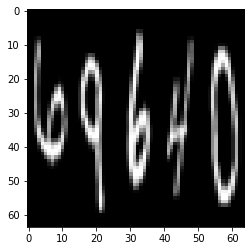

Predicted Value is 69640


In [17]:
predict_image(test_images[70])